In [275]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import random

import healpy

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from astropy.table import Table, vstack
from astropy.io import fits

from shapely.geometry import Polygon as poly_shapely
from shapely.ops import cascaded_union

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
from damascus import io
from damascus import hsc
from damascus import shape
from damascus import utils
from damascus import sweep

In [268]:
def get_overlapped_sweep(sweep_list, hsc_fdfc_pkl):
    '''Get the list of overlapped Sweep catalogs.
    '''
    # Decode the Sweep lists into coordinates of the box regions
    sweep_boxes = [sweep.sweep_to_box(name) for name in sweep_list]

    # Read HSC FDFC region files
    hsc_fdfc_regions = io.read_from_pickle(hsc_fdfc_pkl)

    # Combine the HSC fields together
    hsc_fdfc_union = cascaded_union(
        [poly_shapely(hsc_fdfc_regions[idx + 1])
         for idx in np.arange(len(hsc_fdfc_regions))])

    # Get the list of overlapped sweep catalogs
    sweep_overlap = list(
        np.asarray(sweep_list)[
            [hsc_fdfc_union.intersects(poly_shapely(box)) 
             for box in sweep_boxes]])
    
    return sweep_overlap

# Filter DECaLS Sweep catalog through HSC FDFC healpix mask

- Using local DR9SV catalog as a test
- Filter through HSC S19A internal release

In [145]:
decals_dir = '/Volumes/astro5/massive/decals/dr9sv/'
sweep_dir = os.path.join(decals_dir, 'sweep')
sweep_list = io.find_files(sweep_dir, 'sweep*.fits')

# Find 50 sweep*.fits files


In [165]:
_ = io.save_to_pickle(sweep_list, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweeps.pkl')

### Find all the sweep catalog

In [164]:
s19a_fdfc_pkl = '../../damascus/data/hsc/s19a_fdfc_borders_poly.pkl'
s18a_fdfc_pkl = '../../damascus/data/hsc/s18a_fdfc_borders_poly.pkl'

sweep_s19a_overlap = get_overlapped_sweep(sweep_list, s19a_fdfc_pkl)
sweep_s18a_overlap = get_overlapped_sweep(sweep_list, s18a_fdfc_pkl)

print(len(sweep_s18a_overlap), len(sweep_s19a_overlap))

19 20


In [166]:
_ = io.save_to_pickle(sweep_s19a_overlap, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweep_s19a_overlap.pkl')
_ = io.save_to_pickle(sweep_s18a_overlap, '../../damascus/data/decals/dr9sv/decals_dr9sv_sweep_s18a_overlap.pkl')

(-15.0, 50.0)

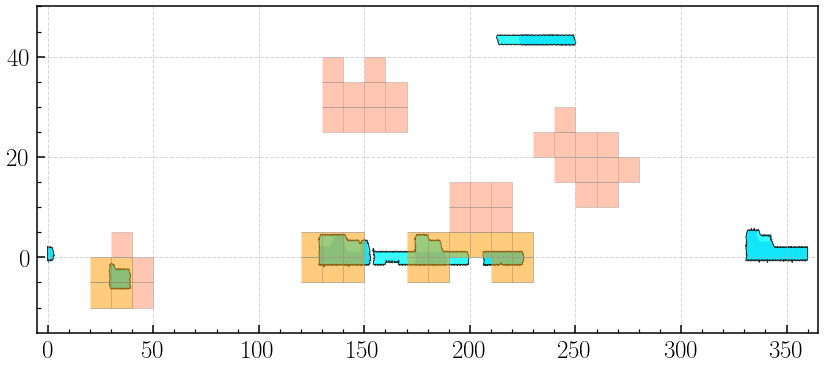

In [163]:
s19a_poly = io.read_from_pickle('../../damascus/data/hsc/s19a_fdfc_poly.pkl')
s18a_poly = io.read_from_pickle('../../damascus/data/hsc/s18a_fdfc_poly.pkl')

s18a_polygons = [Polygon(s18a_poly[idx + 1], closed=False) for idx in np.arange(len(s18a_poly))]
s19a_polygons = [Polygon(s19a_poly[idx + 1], closed=False) for idx in np.arange(len(s19a_poly))]

sweep_boxes = [sweep.sweep_to_box(name) for name in sweep_list]
sweep_polygons = [Polygon(box, closed=False) for box in sweep_boxes]

overlap_boxes = [sweep.sweep_to_box(name) for name in sweep_s19a_overlap]
overlap_polygons = [Polygon(box, closed=False) for box in overlap_boxes]

# 
fig, ax = plt.subplots(figsize=(14, 6))

ax.add_collection(PatchCollection(s18a_polygons, facecolor='royalblue', edgecolor='none', alpha=0.8))
ax.add_collection(PatchCollection(s19a_polygons, facecolor='cyan', edgecolor='k', alpha=0.8))

ax.add_collection(PatchCollection(sweep_polygons, edgecolor='gray', facecolor='orangered', alpha=0.3))
ax.add_collection(PatchCollection(overlap_polygons, edgecolor='gray', facecolor='gold', alpha=0.3))

ax.set_xlim(-5, 365)
ax.set_ylim(-15, 50)

## Sandbox

In [ ]:
s19a_fdfc = '/Users/song/Downloads/s19a_fdfc_hp_contarea_izy-gt-5_trimmed.fits'

In [264]:
%timeit sweep_test = sweep.SweepCatalog('/Users/song/Downloads/sweep-020m005-030p000.fits', read_in=False)

48.1 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [265]:
%timeit sweep_test = sweep.SweepCatalog('/Users/song/Downloads/sweep-020m005-030p000.fits', read_in=True)

128 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [417]:
sweep_obj = sweep.SweepCatalog('/Users/song/Downloads/sweep-020m005-030p000.fits', read_in=True)
sweep_obj.demography()

# There are 48692 objects in the catalog
# DEV: 2243
# DUP: 3
# EXP: 4113
# PSF: 15973
# REX: 26256
# SER: 104


In [418]:
flux_r_lim = utils.mag_to_flux(23.0, zeropoint=22.5)
flux_z_lim = utils.mag_to_flux(23.0, zeropoint=22.5)

sweep_obj.select('TYPE', '!=', 'PSF', verbose=True)
sweep_obj.select('TYPE', '!=', 'DUP', verbose=True)
sweep_obj.select('FLUX_R', '>=', flux_r_lim, verbose=True)
sweep_obj.select('FLUX_Z', '>=', flux_z_lim, verbose=True)

TYPE != PSF selects 32719 objects
TYPE != DUP selects 32716 objects
FLUX_R >= 0.6309573444801932 selects 8660 objects
FLUX_Z >= 0.6309573444801932 selects 8525 objects


In [420]:
s19a_match = sweep_obj.healpix_mask(s19a_fdfc, verbose=True)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
# Find 8525 objects inside the FDFC region


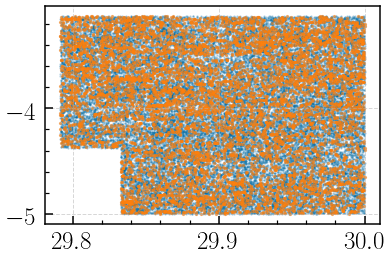

In [422]:
plt.scatter(sweep_test.data['RA'], sweep_test.data['DEC'], s=2, alpha=0.2)
plt.scatter(s19a_match['RA'], s19a_match['DEC'], s=5, alpha=0.5)
#plt.plot(borders[:, 0], borders[:, 1], c='r')
#plt.plot(sweep_test.data['RA'][hull.vertices], sweep_test.data['DEC'][hull.vertices])

In [369]:
H, ra_edges, dec_edges = np.histogram2d(
    sweep_test.data['RA'], sweep_test.data['DEC'], 
    range=[sweep_test.obj_ra_range, sweep_test.obj_dec_range],
    bins=[10, 5])

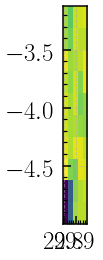

In [371]:
plt.imshow(H, interpolation='none', origin='low', aspect='equal',
           extent=[ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]])

In [11]:
print(sweep_test.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH

In [74]:
matches_use = list(filter(None, matches)) 

print(len(matches_use))

18


In [76]:
dr9sv_matches = vstack(matches_use)

In [77]:
len(dr9sv_matches)

16695183

In [ ]:
dr9sv_matches.write('/Volumes/astro5/massive/decals/dr9sv/dr9sv_sweep_s19a_fdfc_all.fits')